**Neural networks for road segmentation**
========================

Your next task is to train neural network to segment road on images from car cams.

The original dataset is provided by Karlsruhe Institute of Technology (http://www.cvlibs.net/datasets/kitti/eval_road.php). Their images are ±370x1270, but, for simlictiy, we will use 370x370 squares.

One can download the dataset from https://disk.yandex.ru/d/QPOw4hk84-se_w

Here is an example of input data with corresponding ground truth:

In [1]:
import os
import cv2
import numpy as np

import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import albumentations as A
from math import ceil
from IPython.display import clear_output
from torch.utils.data import DataLoader
import torch.nn as nn
from functools import partial
from tqdm.auto import tqdm
from typing import Callable, Any
from collections import defaultdict
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, "..")

from plotter import History, Plotter

In [3]:

def get_paths(path):
    _, _, filenames = next(os.walk(path))

    images_paths = []
    for filename in sorted(filenames):
        images_paths.append(os.path.join(path, filename))

    return np.stack(images_paths)

class RoadDataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, images, masks, transform, aug=None):
        self.images_paths = sorted(images)
        self.masks_paths = sorted(masks)
        self.transform = transform
        self.aug = aug

        self.images = []
        self.masks = []
        self.cache_samples()

    def cache_samples(self):
        for im_name, mask_name in tqdm(zip(self.images_paths, self.masks_paths),
                                       total=len(self.images_paths)):
            self.images.append(cv2.imread(im_name)[:,:,::-1])  # ::-1 to convert from BGR to RGB
            mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE) > 0
            self.masks.append(mask.astype(np.uint8))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        if self.aug:
            t = self.aug(image=image, mask=mask)
            image, mask = t["image"], t["mask"]
        image = image.astype(np.float32) / 255
        mask = mask.astype(image.dtype)
        image, mask = [self.transform(t).float() for t in (image, mask)]

        return image, mask


In [4]:

orig_size = 370
cropped_size = 370
padded_size = ceil(370 / 32) * 32

aug = A.Compose([
    A.RandomCrop(width=cropped_size, height=cropped_size),
    A.HorizontalFlip(p=.5),
    A.Rotate(10, border_mode=cv2.BORDER_REFLECT),
    A.RandomBrightnessContrast(p=.5),
    A.RandomGamma(p=.5),
    A.Sharpen(p=.5),
    A.OpticalDistortion(distort_limit=.05, p=.3),
    A.PadIfNeeded(padded_size, padded_size, border_mode=cv2.BORDER_CONSTANT)
])


In [5]:
clear_output()

transform = transforms.Compose([
    transforms.ToTensor(),
])

X_train = get_paths("data/train/images")
y_train = get_paths("data/train/gt")
X_val = get_paths("data/test/images")
y_val = get_paths("data/test/gt")

train_dataset = RoadDataset(X_train, y_train, transform, aug=aug)
val_dataset = RoadDataset(X_val, y_val, transform,
                          aug=A.PadIfNeeded(padded_size, padded_size, border_mode=cv2.BORDER_CONSTANT))

  0%|          | 0/648 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

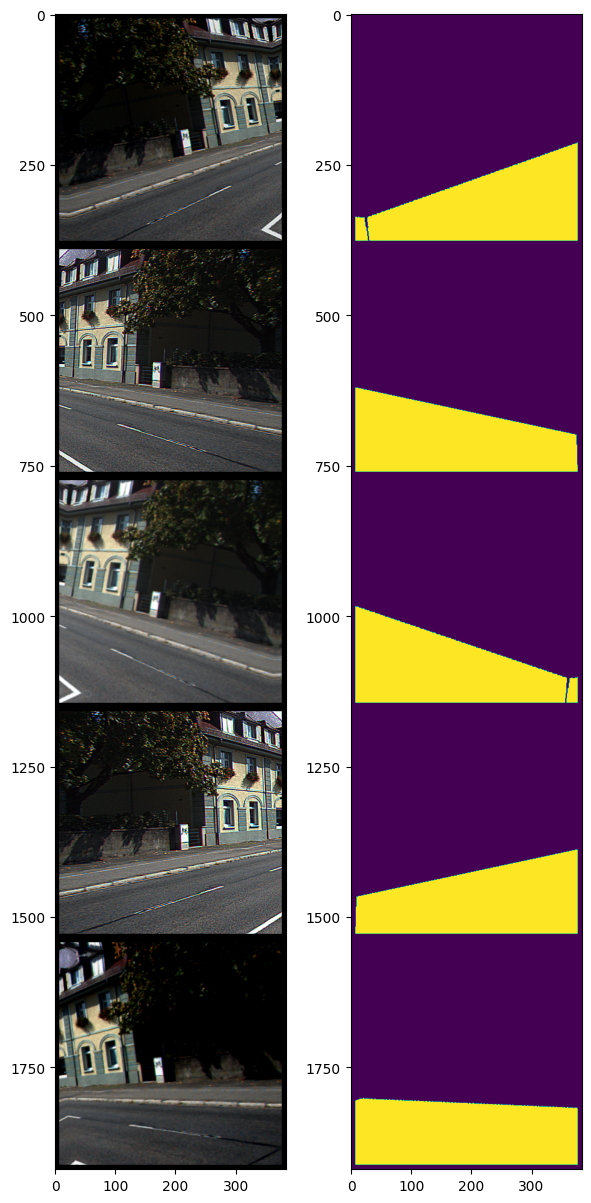

In [6]:
idx = 110
rows = 5
image, mask = map(torch.hstack, zip(*[train_dataset[idx] for _ in range(rows)]))
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 15))
ax1.imshow(image.permute(1, 2, 0))
ax2.imshow(mask.permute(1, 2, 0))

Workflow:
---
* Choose correct loss function, write training loop and code for testing. Feel free to use previous HW for inspiration. 
* Train any segmentation neural network from scratch (for example U-Net) and achieve >= 0.75 IoU on test set (40% points). See function to calculate the metric below.
* Use any pretrained model for image classification, convert it for segmentation by adding decoder (don't forget skip-connections) or usign dilated convolutions and achieve >= 0.87 IoU  on test set (60% points).

You're not allowed to do only one thing: train your network on test set.

----
Your final solution will consist of an ipython notebook with code (for final networks training + any experiments with data) and test metric calculation.

Feel free to ask in Telegram chat if something is not clear :3


In [7]:
print(f"Dataset length {len(train_dataset)}")

Dataset length 648


In [8]:
def central_crop(images, size):
    current_size = images.size(2)
    border_len = (current_size - size) // 2
    return images[:, :, border_len:current_size-border_len, border_len:current_size-border_len]

def calc_iou(prediction, ground_truth, mid=.5):
    pred = prediction > mid
    y = ground_truth > 0
    nom = torch.logical_and(pred, y).sum()
    denom = torch.logical_or(pred, y).sum()
    return nom.item(), denom.item()

def agg_iou(results):
    nom, denom = np.array(results).sum(axis=0)
    return nom / denom

In [9]:
Metrics = dict[
    str, 
    tuple[
        Callable[[torch.Tensor, torch.Tensor], Any],
        Callable[[list[Any]], float],
    ] | Callable[[torch.Tensor, torch.Tensor], float]]

def _loopa(model: nn.Module, dataloader: DataLoader, *, device: str,
           loss_fn, optim, metrics: Metrics,
           is_train: bool = True, accum_grad: int = 1):
    
    metric_lists = defaultdict(list)
    for metric, val in metrics.items():
        try:
            iter(val)
        except TypeError:
            metrics[metric] = (val, np.mean)
    
    optim.zero_grad()
    for i, (X, y) in enumerate(tqdm(dataloader)):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y) / accum_grad
        
        if is_train:
            loss.backward()
            if not (i + 1) % accum_grad:
                optim.step()
                optim.zero_grad()
            
        with torch.no_grad():
            for metric, (fn, _) in metrics.items():
                if metric == "loss":
                    metric_lists["loss"].append(loss.item() * accum_grad)
                else:
                    metric_lists[metric].append(fn(y_pred, y))
    
    if is_train and (i + 1) % accum_grad:
        # optim.step()
        optim.zero_grad()
    
    metric_results = {}
    for key, (_, agg) in metrics.items():
        metric_results[key] = agg(metric_lists[key])
    
    return metric_results

def loopa(*args, is_train: bool = True, **kwargs):
    if is_train:
        model.train()
        return _loopa(*args, **kwargs, is_train=is_train)
    
    with torch.no_grad():
        model.eval()
        ret = _loopa(*args, **kwargs, is_train=is_train)
        model.train()
        return ret


In [10]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
crop_train = partial(central_crop, size=cropped_size)
crop_eval = partial(central_crop, size=orig_size)

In [12]:
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size)

model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                       in_channels=3, out_channels=1, init_features=32,
                       pretrained=False)
model.to(device)

loss_fn = nn.BCELoss()

loss_fn_train = lambda *args: loss_fn(*map(crop_train, args))
loss_fn_eval = lambda *args: loss_fn(*map(crop_eval, args))
optim = torch.optim.Adam(model.parameters())

history = History()

Using cache found in /home/photon/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [95]:
# torch.save(model.state_dict(), "unet.pth")

In [19]:
clear_output()
num_epochs = 100

params = dict(
    model=model,
    device=device,
    optim=optim,
)

plotter = Plotter(bound_history=history)
while len(history) < num_epochs:
    history.push_epoch(
        loopa(**params, dataloader=train_loader, loss_fn=loss_fn_train, is_train=True, accum_grad=4,
              metrics={
                  "loss":None,
                  "iou": (lambda *args: calc_iou(*map(crop_train, args)), agg_iou)
                  }),
        loopa(**params, dataloader=val_loader, loss_fn=loss_fn_eval, is_train=False,
              metrics={
                  "loss":None,
                  "iou": (lambda *args: calc_iou(*map(crop_eval, args)), agg_iou)
                  }),
    )
    
    plotter.plot()
    

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

FigureWidget({
    'data': [],
    'layout': {'annotations': [{'font': {'size': 16},
                                'showarrow': False,
                                'text': 'iou',
                                'x': 0.225,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'loss',
                                'x': 0.775,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'}],
               'height': 600,
               'showlegend': True,
              

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

KeyboardInterrupt: 

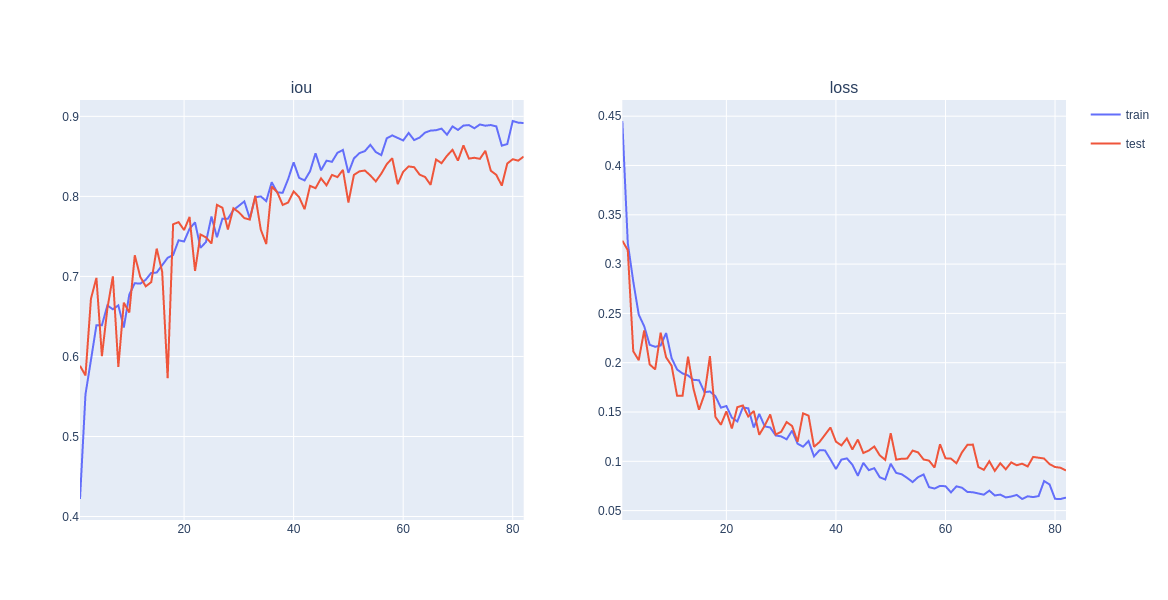

In [22]:
plotter.draw_no_widget()

In [83]:
clear_output()
train_dataset.aug = val_dataset.aug

with torch.no_grad():
    res = [(model(X.to(device)).detach().cpu(), y) for X, y in tqdm(train_loader)]

  0%|          | 0/81 [00:00<?, ?it/s]

In [84]:
from utils import map
preds, y_true = map([crop_eval, torch.vstack], zip(*res))
print(preds.shape)

torch.Size([648, 1, 370, 370])


In [85]:
from sklearn.metrics import roc_curve
def get_optimal_threshold(y_pred, y_true):
    y_true, y_pred = y_true.flatten().to(bool).numpy(), y_pred.flatten().numpy()
    fpr, tpr, thresholds = roc_curve(y_true.flatten(), y_pred.flatten())
    
    pos = sum(y_true)
    neg = len(y_true) - pos
    # iou = tp / (tp + fn + fp) = tp / (pos + fp)
    # tpr = tp / pos, fpr = fp / neg
    iou = tpr * pos / (pos + neg * fpr)
    
    arg = iou.argmax()
    print("iou on threshold=0.5:", iou[((thresholds - .5)**2).argmin()])
    print(f"iou on threshold={thresholds[arg]:.2f}: {iou[arg]}")
    return thresholds[arg]

In [86]:
threshold = get_optimal_threshold(preds, y_true)

iou on threshold=0.5: 0.910574566677933
iou on threshold=0.59: 0.912750782760273


In [90]:
old_iou = loopa(**params, dataloader=val_loader, loss_fn=loss_fn_eval, is_train=False,
        metrics={
            "iou": (lambda *args: calc_iou(*map(crop_eval, args)), agg_iou)
            })["iou"]
new_iou = loopa(**params, dataloader=val_loader, loss_fn=loss_fn_eval, is_train=False,
        metrics={
            "iou": (lambda *args: calc_iou(*map(crop_eval, args), 0.5955255), agg_iou)
            })["iou"]
clear_output()
print(f"on val, {old_iou=} -> {new_iou=}")
print(f"delta={new_iou - old_iou}")

on val, old_iou=0.8486512815069789 -> new_iou=0.8531382348235372
delta=0.004486953316558351


forward code is merged from `torchvision/models/resnet.py` (`Resnet.forward`) and `torch/hub/mateuszbuda_brain-segmentation-pytorch_master/unet.py` (`UNet.forward`)

In [12]:
from torchvision.models import resnet152, ResNet152_Weights

UNet = type(torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', pretrained=False))

class EncoderDecoder(nn.Module):
    def __init__(self, features=64, in_channels=3, out_channels=1) -> None:
        super().__init__()
        self.resnet = resnet152(weights=ResNet152_Weights.IMAGENET1K_V2)
        self.resnet.fc = nn.Identity()
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # from UNet.__init__
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.upconv4 = nn.ConvTranspose2d(features * 32, features * 16, kernel_size=2, stride=2)
        self.decoder4 = UNet._block((features * 16) * 2, features * 16, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.decoder3 = UNet._block((features * 8) * 2, features * 8, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder2 = UNet._block((features * 4) * 2, features * 4, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(features * 4, features, kernel_size=4, stride=4)
        self.decoder1 = UNet._block((features) * 2, features, name="dec1")

        self.conv = nn.Conv2d(in_channels=features, out_channels=out_channels, kernel_size=1)
    
    def forward(self, X):
        # encoder
        x = self.resnet.conv1(X) # 1/2
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        enc2 = self.resnet.layer1(x) # 1/4
        enc3 = self.resnet.layer2(enc2) # 1/8
        enc4 = self.resnet.layer3(enc3) # 1/16
        bottleneck = self.resnet.layer4(enc4) # 1/32
        
        
        # decoder
        enc1 = self.encoder1(X)
        
        dec4 = self.upconv4(bottleneck) # 1/16
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4) # 1/8
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3) # 1/4
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2) # 1
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        return torch.sigmoid(self.conv(dec1))

        

Using cache found in /home/photon/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [14]:
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size)

model = EncoderDecoder()
model.to(device)

loss_fn = nn.BCELoss()

loss_fn_train = lambda *args: loss_fn(*map(crop_train, args))
loss_fn_eval = lambda *args: loss_fn(*map(crop_eval, args))
optim = torch.optim.Adam(model.parameters())

history = History()

In [ ]:
class EarlyStopper:
    def __init__(self, model, metric, history, )

In [15]:
clear_output()
num_epochs = 100

params = dict(
    model=model,
    device=device,
    optim=optim,
)

plotter = Plotter(bound_history=history)
while len(history) < num_epochs:
    history.push_epoch(
        loopa(**params, dataloader=train_loader, loss_fn=loss_fn_train, is_train=True, accum_grad=4,
              metrics={
                  "loss":None,
                  "iou": (lambda *args: calc_iou(*map(crop_train, args)), agg_iou)
                  }),
        loopa(**params, dataloader=val_loader, loss_fn=loss_fn_eval, is_train=False,
              metrics={
                  "loss":None,
                  "iou": (lambda *args: calc_iou(*map(crop_eval, args)), agg_iou)
                  }),
    )
    
    plotter.plot()
    

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

FigureWidget({
    'data': [],
    'layout': {'annotations': [{'font': {'size': 16},
                                'showarrow': False,
                                'text': 'iou',
                                'x': 0.225,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'loss',
                                'x': 0.775,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'}],
               'height': 600,
               'showlegend': True,
              

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [16]:
plotter.draw_no_widget()

In [ ]:
torch.save(model.state_dict(), "01_inf.pth")

Dataset is small so actively use data augmentation: rotations, flip, color-change etc. to prevent overfitting.

Most likely you'll have to pad your images to 512x512 (it divides by 2^5=32, like U-Net wants). Use PadIfNeeded from Albumentations and central crop (see below) after prediction to calculate loss/metrics (you don't want to pay attention on padded values).

----
There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for the "road" class, or add class weights in optimized loss. You also can try to use softIoU or DICE loss.

Good luck!